### Hector Daniel Juarez Leonel

# Continuous Bag of Words Implementation en TensorFlow 

El método CBOW intenta predecir el centro de una palabra desde el contexto de las palabras vecinas utilizando una ventana de número de palabras específica.

In [ ]:
import tensorflow as tf
import numpy as np

#Tamaño del embeding
emb_dims = 128
#ratio de aprendizaje que se ocupa en el optimizador de la red neuronal
learning_rate = 0.001

#-------------------------------------------------
# to one hot the words
#------------------------------------------------
def one_hot(ind,vocab_size):
    rec = np.zeros(vocab_size)
    rec[ind] = 1
    return rec


#----------------------------------------------------
# Crea los datos de prueba a partir de un texto y una ventana que define el numero de palabras
# vecinas que se toman en cuenta para relacionar a cada una de las palabras del enunciado,
# en el ultimo for de esta funcion explico de mejor manera esto.   
#----------------------------------------------------
def create_training_data(corpus_raw,WINDOW_SIZE = 2):
    words_list = []
    
    #El siguiente for obtiene cada una de las palabras del corpus_raw
    for sent in corpus_raw.split('.'):
        for w in sent.split():
            if w != '.':  
                # Elimina el punto si lo tiene una palabra
                words_list.append(w.split('.')[0])     

    words_list = set(words_list) # al usar "set" elimina los duplicados

    word2ind = {} # Define un diccionario para convertir la palabra a un indice
    ind2word = {} # Define un diccionario para obtener la palabra a partir del índice

    vocab_size = len(words_list) # Cuenta el número de palabras únicas en el vocabulario

    # Básicamente en las siguientes lineas realiza una tokenización
    for i,w in enumerate(words_list): # Build the dictionaries  
        word2ind[w] = i
        ind2word[i] = w
        
    print word2ind
    sentences_list = corpus_raw.split('.')
    sentences = []

    #En el siguiente for obtiene una lista de sentencias separadas por puntos.
    for sent in sentences_list:
        sent_array = sent.split()
        sent_array = [s.split('.')[0] for s in sent_array] #en esta linea se encarga de 
                            #eliminar el punto de las ultimas palabras de cada oración
        sentences.append(sent_array) #y agrega las palabras aun arreglo de sentencias
    
    data_recs = []  # aqui se guardarán parejas conformadas por un conjunto de palabras
                    # "rec" y la palabra con la que se relaciona w

    
    #for que recorre cada una de las oraciones
    for sent in sentences:
        #for que recorre cada uno de los índices y las palabras de la oración
        for ind,w in enumerate(sent):
            rec = [] #aqui se guardarán las palabras a "grabar"
            # el siguiente for es muy interesante ya que es una ventana que se va recorriendo
            # el valor de max como indice inferior evita llegar a un número negativo y
            # el valor de min del indice superior evita que se salga del arreglo
            for nb_w in sent[max(ind - WINDOW_SIZE, 0) : min(ind + WINDOW_SIZE, len(sent)) + 1] : 
                #comprueba que n_w no sea igual a w, pues no va a asociar a la palabra consigo misma
                if nb_w != w:
                    rec.append(nb_w)
                #agrega las palabras "rec" que se asocian con w
                data_recs.append([rec,w])
    
    
    x_train,y_train = [],[] #inicialización de variables de entrenamieto con sus etiquetas

    # a continuación, con los valores de data_recs, va a crear un vector unico para cada palabra,
    # lo veo similar a lo que realiza job, pero en este caso, relacionando a una palabra con sus
    # palabras vecinas en la oración usando one_hot (con ayuda de la ventana),  a cada palabra le 
    # suma el valor de las palabras que la componen, por ejemplo, "hola"=[0,0,0,1], 
    # "como"=[0,0,1,0] y "estas"=[0,1,0,0], entonces que relaciona 
    # la palabra con sus palabras vecinas en la oracion, "como" tendrá el valor de [0,0.5,1,0.5]
    for rec in data_recs: #for que recorre todas las parejas obtenidas en la seccion anterior
        input_ = np.zeros(vocab_size) #inicializa el vector en ceros
        for i in xrange(WINDOW_SIZE-1): #for que recorre las palabras vecinas de la palabra w en rec
            input_ += one_hot(word2ind[ rec[0][i] ], vocab_size) #suma cada una de las palabras en su forma onehot
        input_ = input_/len(rec[0]) #divide el vector entre el tamaño de las palabras vecinas
        x_train.append(input_) #agrega el vector al conjunto de datos de entrenamiento
        y_train.append(one_hot(word2ind[ rec[1] ], vocab_size)) #agrega la salida esperada que corresponde a w
        
    return x_train,y_train,word2ind,ind2word,vocab_size #retorna el conjunto de entrenamiento con su
        #respectivo diccionario de palabra a indice, de indice a palabra y el tamaño del vocabulario

#a continuación se encuentra el corpus de prueba
corpus_raw = "Deep Learning has evolved from Artificial Neural Networks which has been there since the 1940s. Neural Networks are interconnected networks of processing units called artificial neurons, that loosely mimics axons in a biological brain. In a biological neuron, the Dendrites receive input signals from various neighboring neurons, typically greater than 1000. These modified signals are then passed on to the cell body or soma of the neuron where these signals are summed together and then passed on to the Axon of the neuron. If the received input signal is more than a specified threshold, the axon will release a signal which again will pass on to neighboring dendrites of other neurons. Figure 2-1 depicts the structure of a biological neuron for reference.The artificial neuron units are inspired from the biological neurons with some modifications as per convenience. Much like the dendrites the input connections to the neuron carry the attenuated or amplified input signals from other neighboring neurons. The signals are passed onto the neuron where the input signals are summed up and then a decision is taken what to output based on the total input received. For instance, for a binary threshold neuron output value of 1 is provided when the total input exceeds a pre-defined threshold, otherwise the output stays at 0. Several other types of neurons are used in artificial neural network and their implementation only differs with respect to the activation function on the total input to produce the neuron output. In Figure 2-2 the different biological equivalents are tagged in the artificial neuron for easy analogy and interpretation."
#pasa el corpus a minusculas
corpus_raw = (corpus_raw).lower()
#----------------------------------------------------------------------
# genera el conjunto de datos de entrenamiento a partir del corpus
#-----------------------------------------------------------------------
x_train,y_train,word2ind,ind2word,vocab_size= create_training_data(corpus_raw,2)

#---------------------------------------------
# Ahora, construye la red neuronal y comienza con el entrenamiento
#---------------------------------------------
# A diferencia de otros códigos que usan keras, aqui usa directamente tensorflow
# y se ve paso a paso lo que internamente realiza keras
#----------------------------------------------
# crea los placeholder que sirven como entradas de tensorflow, aunque y en realidad es una salida,
# tambien se comporta como entrada porque se debe de poner el dato que se espera como salida, es decir,
# se "introduce" el dato de salida
x = tf.placeholder(tf.float32,[None,vocab_size])
y = tf.placeholder(tf.float32,[None,vocab_size])
#---------------------------------------------
# Define la matriz de pesos y el bias de forma manual, estableciendo que comienza con
# valores aleatorios y definiendo la media y desviación estandar para el generador de estos
#----------------------------------------------

#crea dos W y 2 bias para la entrada y salida de una capa oculta
W = tf.Variable(tf.random_normal([vocab_size,emb_dims],mean=0.0,stddev=0.02,dtype=tf.float32))
b = tf.Variable(tf.random_normal([emb_dims],mean=0.0,stddev=0.02,dtype=tf.float32))
W_outer = tf.Variable(tf.random_normal([emb_dims,vocab_size],mean=0.0,stddev=0.02,dtype=tf.float32))
b_outer = tf.Variable(tf.random_normal([vocab_size],mean=0.0,stddev=0.02,dtype=tf.float32))

hidden = tf.add(tf.matmul(x,W),b)
logits = tf.add(tf.matmul(hidden,W_outer),b_outer)
#define la funcion de costo y el optimizador
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#establece el numero de epocas y el tamaño del batch
epochs,batch_size = 100,10
batch = len(x_train)//batch_size

# entrenamiento
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('was here') #print para saber si crea la sesion correctamente
    for epoch in xrange(epochs): #for para recorrer cada una de las epocas
        batch_index = 0 
        for batch_num in xrange(batch): #for para recorrer cada uno de lo batch por epoca
            x_batch = x_train[batch_index: batch_index +batch_size] #selecciona el batch según el 
                #indice del batch tanto para los datos de entrenamiento como para las etiquetas
            y_batch = y_train[batch_index: batch_index +batch_size]
            sess.run(optimizer,feed_dict={x: x_batch,y: y_batch}) #aqui se realiza en entrenamiento con
                #el bloque de datos dado
            print('epoch:',epoch,'loss :', sess.run(cost,feed_dict={x: x_batch,y: y_batch}))
    W_embed_trained = sess.run(W) #aqui guarda la matriz de pesos resultante


TSNE plot of the Word Vector Embeddings


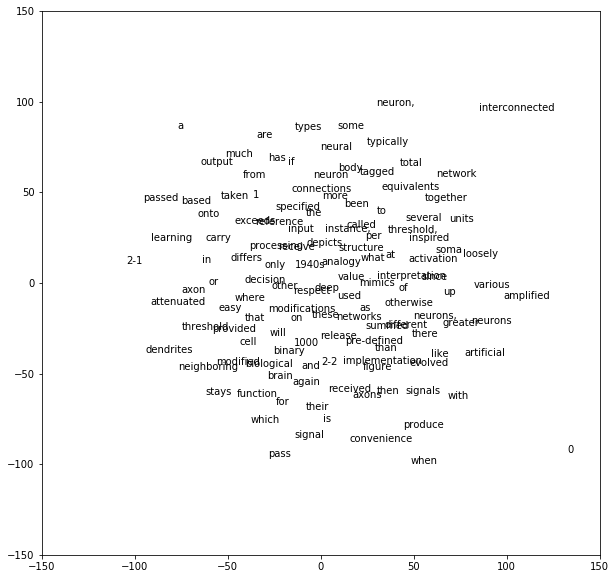

In [8]:
# ya que el embedding da como resultado una matriz muy grande, es dificil de visualizar
# cada uno de los vectores que componen la matriz,
# pero gracias a las técnicas como TSNE que reducen la dimensión de un conjunto de datos 
# es posible visualizarlos
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
W_embedded = TSNE(n_components=2).fit_transform(W_embed_trained)
plt.figure(figsize=(10,10))
for i in xrange(len(W_embedded)):
    # a continuacion utiliza el diccionario de ind2word para obtener la palabra que corresponde a
    # cada indice
    plt.text(W_embedded[i,0],W_embedded[i,1],ind2word[i])

plt.xlim(-150,150)
plt.ylim(-150,150)
print "TSNE plot of the Word Vector Embeddings"


# Conclusiones
Recuerdo que cuando tuvimos la sesión virtual con Job, el ya nos habia mencionado un poco la forma de trabajar del embedding, sin embargo fue una explicación muy corta pues no era el tema a tratar en esa ocasión.

Antes de realizar el ejemplo, no habia entendido como es que realizaba el entrenamiento de la red neuronal, de hecho, lo visualizaba como un autoencoder, pero es diferente, ya que los vectores de entrada no son los mismos que los vectores de salida, los vectores de entrada son vectores que con ayuda de oneshot, continenen "información" de las palabras con las que se relaciona. Lo veo similar a la semántica de una palabrá, pero en vez de definir una palabra a partir de otras palabras, solo busca agrupar aquellas palabras que suelen verse juntas en un texto.

El punto negativo de este tipo de embedding es que depende del tamaño de la ventana y del numero de palabras que se usen
